### 此份報告計算 Foster-Hart risk measurement 的方法是計算過去六十天各股票的報酬和隨機抽各股票的比重，然後計算出六十個 joint returns 並假設每個的機率相同。需要改進的地方
#### 1. 想辦法利用數據 (各股票的returns, variance, correlation) 計算出 joint distribution，在去同時最佳化 Foster-Hart risk measurement。
#### 2. 在計算 Foster-Hart risk measurement 時會解出很大的值，可能的原因是在初始猜測值給太大。經過前人的證明可以得知只會有一個解，但靠近無限處會很接近 0，因此可能是因為這樣才解出很大的值。

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from datetime import datetime
from datetime import date
from sklearn.linear_model import LinearRegression
from datetime import datetime, date, timedelta
from scipy.optimize import minimize
from scipy.optimize import fsolve
from scipy.optimize import root
import statsmodels.api as sm
import statsmodels.formula.api as smf
import yfinance as yf
import time

In [2]:
"""
data: market value
top: companies of top market value
price: stock price at t
high: previous 252 days highest price at t
ratio: stock price at t / high
r: daily returns
buy: long stock tickers
buy_price: the price of the buy stocks at buying day
"""

'\ndata: market value\ntop: companies of top market value\nprice: stock price at t\nhigh: previous 252 days highest price at t\nratio: stock price at t / high\nr: daily returns\nbuy: long stock tickers\nbuy_price: the price of the buy stocks at buying day\n'

In [3]:
data=pd.read_csv('market_value.csv')
data=data.T
data.columns=data.iloc[0]
data=data.iloc[1:]
data.index=pd.to_datetime(data.index)
data=data.T
data

,2011-12-30,2012-06-29,2012-12-28,2013-06-28,2013-12-31,2014-06-30,2014-12-31,2015-06-30,2015-12-31,2016-06-30,...,2018-06-29,2018-12-28,2019-06-28,2019-12-31,2020-06-30,2020-12-31,2021-06-30,2021-12-30,2022-06-30,2022-12-30
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1101 台泥,"129,226","130,518","143,625","136,241","170,763","166,886","160,240","143,810","100,796","118,334",...,"179,840","181,847","235,226","238,848","233,655","251,003","312,303","294,011","241,947","240,806"
1102 亞泥,"106,651","117,473","120,674","119,220","127,207","134,787","131,096","122,692","92,103","93,784",...,"112,608","114,121","159,837","161,181","146,559","145,215","171,850","157,069","155,312","145,383"
1103 嘉泥,"8,937","10,219","10,759","11,069","12,196","12,390","10,992","9,360","7,375","6,469",...,"9,955","10,537","13,249","17,316","13,675","14,760","17,355","16,077","14,024","13,481"
1104 環泥,"8,031","7,850","9,662","10,296","17,059","17,150","15,892","16,600","14,136","13,759",...,"13,137","12,353","13,040","12,811","11,765","15,164","15,262","14,118","14,379","14,510"
1108 幸福,"2,149","2,456","2,703","2,914","3,395","3,654","4,168","4,290","4,087","4,087",...,"3,213","2,971","2,821","3,392","3,979","5,140","5,545","4,816","4,331","4,351"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9951 皇田,"1,955","2,176","3,052","4,988","9,063","10,935","8,501","8,763","12,508","12,246",...,"8,801","5,932","6,179","6,808","5,625","6,838","7,026","5,910","4,831","4,876"
9955 佳龍,"2,989","2,509","3,128","2,115","2,182","2,167","1,893","1,795","1,295","1,377",...,"1,300","1,249","2,327","1,951","1,734","2,038","1,992","1,780","1,982","2,044"
9958 世紀鋼,"1,077","1,171","1,768","1,725","2,665","2,410","1,992","1,699","1,855","1,840",...,"11,782","13,543","13,586","15,121","17,667","24,609","30,946","25,556","25,677","20,590"


In [4]:
data.columns

DatetimeIndex(['2011-12-30', '2012-06-29', '2012-12-28', '2013-06-28',
               '2013-12-31', '2014-06-30', '2014-12-31', '2015-06-30',
               '2015-12-31', '2016-06-30', '2016-12-30', '2017-06-30',
               '2017-12-29', '2018-06-29', '2018-12-28', '2019-06-28',
               '2019-12-31', '2020-06-30', '2020-12-31', '2021-06-30',
               '2021-12-30', '2022-06-30', '2022-12-30'],
              dtype='datetime64[ns]', freq=None)

In [5]:
# 將數據中金額處理乾淨
for i in data.columns:
    mv_list=[]
    for j in data[i]:
        if(type(j)==str):
            j=int(j.replace(',', ''))
        mv_list.append(j)
    data[i]=mv_list
    
Set=set()
top=[]
for i in data.columns:
    (top.append(np.array(data[i].dropna().sort_values(ascending=False).head(100).index)))
    
for i in top:
    for j in i:
        Set.add(j)
len(Set)

180

In [6]:
price=pd.read_csv('price.csv')
price['年月日']=pd.to_datetime(price['年月日'])
price.sort_values(by='年月日', inplace=True, ascending=True)
price=price.reset_index(drop=True)
price=price.set_index(price['年月日']).drop(columns={"年月日"})
price

,2376 技嘉,2345 智邦,2492 華新科,3044 健鼎,2603 長榮,2344 華邦電,4174 浩鼎,2324 仁寶,2049 上銀,2618 長榮航,...,8436 大江,2356 英業達,6456 GIS-KY,6446 藥華藥,5871 中租-KY,4904 遠傳,2609 陽明,5483 中美晶,2002 中鋼,4743 合一
年月日,,,,,,,,,,,,,,,,,,,,,
2010-01-04,12.0479,7.6316,15.9091,50.8447,26.4646,7.4964,NaN,19.4314,24.0994,8.7007,...,NaN,8.1446,NaN,NaN,NaN,19.9549,17.1580,49.3947,18.5019,NaN
2010-01-05,11.8128,7.5826,14.9612,50.1252,27.4124,7.6477,NaN,19.3431,23.3088,8.8871,...,NaN,8.1660,NaN,NaN,NaN,19.9025,17.5082,49.1143,18.5291,NaN
2010-01-06,11.9500,7.5337,15.0436,48.9260,26.9749,7.5442,NaN,19.5197,23.3088,8.8250,...,NaN,8.2087,NaN,NaN,NaN,19.9025,17.5782,49.2825,18.5833,NaN
2010-01-07,11.8128,7.5093,15.2497,49.4057,27.1208,7.4327,NaN,19.9614,23.7773,8.6696,...,NaN,8.1018,NaN,NaN,NaN,19.5097,17.5782,47.8809,18.4477,NaN
2010-01-08,11.9500,7.4359,15.3733,49.4057,28.5789,7.3291,NaN,20.1380,24.8022,8.8871,...,NaN,8.1873,NaN,NaN,NaN,19.6406,17.8584,47.4884,18.9089,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,105.0000,236.5000,79.0000,95.7000,162.5000,20.0000,78.1,23.0000,181.0000,28.1500,...,175.0,26.1000,92.5,482.5,215.5,66.3000,65.0000,140.1666,30.6000,258.0
2022-12-27,106.0000,238.0000,79.9000,96.8000,162.5000,20.0500,76.2,23.0000,183.5000,28.4500,...,177.5,26.1500,92.8,481.0,219.5,66.2000,65.1000,140.6567,30.3000,264.5
2022-12-28,105.5000,233.5000,78.5000,95.3000,159.0000,19.4500,72.3,22.9500,183.0000,28.2000,...,171.0,26.1000,89.3,475.0,215.0,65.7000,63.9000,135.2657,30.6000,257.0


In [7]:
for i in price.columns:
    try:
        price[i]=price[i].astype('float')
    except:
        a=[]
        for j in price[i]:
            try:
                a.append(j.replace(',', ''))
            except:
                a.append(j)
        price[i]=a
        price[i]=price[i].astype('float')

In [8]:
high=price.copy()
count=0
for i in range(252, price.shape[0]):
    high.iloc[i]=np.max(np.array(price.iloc[i-252: i+1]), axis=0)
high=high[252:]
high

,2376 技嘉,2345 智邦,2492 華新科,3044 健鼎,2603 長榮,2344 華邦電,4174 浩鼎,2324 仁寶,2049 上銀,2618 長榮航,...,8436 大江,2356 英業達,6456 GIS-KY,6446 藥華藥,5871 中租-KY,4904 遠傳,2609 陽明,5483 中美晶,2002 中鋼,4743 合一
年月日,,,,,,,,,,,,,,,,,,,,,
2011-01-04,13.9185,12.4875,19.8658,66.1964,45.1283,7.6876,NaN,21.4629,92.3801,22.9946,...,NaN,8.6362,NaN,NaN,NaN,24.9261,42.1598,68.9938,19.7726,NaN
2011-01-05,13.9185,12.4875,19.8658,66.1964,45.1283,7.6876,NaN,21.4629,92.3801,22.9946,...,NaN,8.6362,NaN,NaN,NaN,24.9261,42.1598,68.9938,19.7726,NaN
2011-01-06,13.9185,12.4875,19.8658,66.1964,45.1283,7.6876,NaN,21.4629,92.3801,22.9946,...,NaN,8.6362,NaN,NaN,NaN,24.9261,42.1598,68.9938,19.7726,NaN
2011-01-07,13.9185,12.4875,19.8658,66.1964,45.1283,7.6876,NaN,21.4629,92.3801,22.9946,...,NaN,8.6362,NaN,NaN,NaN,24.9261,42.1598,68.9938,19.7726,NaN
2011-01-10,13.9185,12.4875,19.8658,66.1964,45.1283,7.6876,NaN,21.4629,92.3801,22.9946,...,NaN,8.6362,NaN,NaN,NaN,24.9261,42.1598,68.9938,19.7726,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,137.4583,290.5000,168.4987,125.7009,317.5521,34.6111,133.2617,25.0583,300.6932,36.6212,...,202.5989,26.1000,99.3243,608.8292,252.5813,84.1698,105.9400,231.0122,36.0383,298.0
2022-12-27,136.5883,290.5000,168.4987,125.7009,317.5521,34.6111,133.2617,25.0583,300.6932,36.6212,...,202.5989,26.1500,99.3243,608.8292,252.5813,84.1698,105.9400,231.0122,36.0383,298.0
2022-12-28,136.5883,290.5000,168.4987,125.7009,317.5521,34.6111,133.2617,25.0583,300.6932,36.6212,...,202.5989,26.1500,99.3243,608.8292,252.5813,84.1698,105.9400,231.0122,36.0383,298.0


In [9]:
ratio=price.iloc[252:]/high
ratio

,2376 技嘉,2345 智邦,2492 華新科,3044 健鼎,2603 長榮,2344 華邦電,4174 浩鼎,2324 仁寶,2049 上銀,2618 長榮航,...,8436 大江,2356 英業達,6456 GIS-KY,6446 藥華藥,5871 中租-KY,4904 遠傳,2609 陽明,5483 中美晶,2002 中鋼,4743 合一
年月日,,,,,,,,,,,,,,,,,,,,,
2011-01-04,1.000000,0.884701,0.819499,0.892594,0.985461,0.901556,NaN,0.861459,0.954545,0.967571,...,NaN,0.919988,NaN,NaN,NaN,0.945130,1.000000,0.847578,0.992682,NaN
2011-01-05,0.977239,0.863736,0.800829,0.892594,0.940228,0.892229,NaN,0.842486,0.964286,0.924326,...,NaN,0.900767,NaN,NaN,NaN,0.936171,0.960133,0.828195,0.980969,NaN
2011-01-06,0.995445,0.878406,0.817425,0.907407,0.967690,0.922277,NaN,0.830214,0.957793,0.916219,...,NaN,0.911744,NaN,NaN,NaN,0.937291,0.986710,0.828195,0.980969,NaN
2011-01-07,0.971168,0.861638,0.817425,0.896296,0.949921,0.937822,NaN,0.825750,0.951299,0.917568,...,NaN,0.911744,NaN,NaN,NaN,0.937291,0.956810,0.818503,0.964866,NaN
2011-01-10,0.971168,0.867932,0.804976,0.877779,0.974154,0.937822,NaN,0.833564,0.925325,0.937842,...,NaN,0.914488,NaN,NaN,NaN,0.940653,0.990033,0.818503,0.975112,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,0.763868,0.814114,0.468846,0.761331,0.511727,0.577849,0.586065,0.917860,0.601942,0.768680,...,0.863776,1.000000,0.931293,0.792505,0.853191,0.787693,0.613555,0.606750,0.849097,0.865772
2022-12-27,0.776055,0.819277,0.474188,0.770082,0.511727,0.579294,0.571807,0.917860,0.610257,0.776872,...,0.876115,1.000000,0.934313,0.790041,0.869027,0.786505,0.614499,0.608871,0.840772,0.887584
2022-12-28,0.772394,0.803787,0.465879,0.758149,0.500705,0.561958,0.542541,0.915864,0.608594,0.770046,...,0.844032,0.998088,0.899075,0.780186,0.851211,0.780565,0.603172,0.585535,0.849097,0.862416


In [10]:
buy=[]
for i in range(ratio.loc[data.columns].shape[0]):
    print(ratio.loc[data.columns].iloc[i][top[i]].sort_values(ascending=False).iloc[:30].index)
    buy.append(ratio.loc[data.columns].iloc[i][top[i]].sort_values(ascending=False).iloc[:30].index)

Index(['9933 中鼎', '2330 台積電', '1216 統一', '9921 巨大', '3045 台灣大', '2412 中華電',
       '4904 遠傳', '2347 聯強', '8299 群聯', '2103 台橡', '2451 創見', '2382 廣達',
       '2301 光寶科', '9904 寶成', '2002 中鋼', '2105 正新', '2207 和泰車', '1434 福懋',
       '2912 統一超', '6505 台塑化', '2227 裕日車', '2395 研華', '2385 群光', '2324 仁寶',
       '3034 聯詠', '4938 和碩', '2357 華碩', '1504 東元', '1227 佳格', '1102 亞泥'],
      dtype='object')
Index(['3045 台灣大', '2227 裕日車', '1216 統一', '2105 正新', '9945 潤泰新', '3034 聯詠',
       '2385 群光', '6176 瑞儀', '9904 寶成', '2395 研華', '2347 聯強', '2301 光寶科',
       '4904 遠傳', '2451 創見', '2890 永豐金', '9921 巨大', '2382 廣達', '2330 台積電',
       '9933 中鼎', '2103 台橡', '2412 中華電', '8299 群聯', '2002 中鋼', '1504 東元',
       '1102 亞泥', '2308 台達電', '5903 全家', '2357 華碩', '4938 和碩', '2912 統一超'],
      dtype='object')
Index(['2881 富邦金', '2395 研華', '1504 東元', '2880 華南金', '2887 台新金', '2412 中華電',
       '5347 世界', '9945 潤泰新', '1102 亞泥', '1101 台泥', '1434 福懋', '2890 永豐金',
       '1789 神隆', '3673 TPK-KY', '4904 遠傳', '9921 巨大', 

In [11]:
r=price.pct_change()
r

,2376 技嘉,2345 智邦,2492 華新科,3044 健鼎,2603 長榮,2344 華邦電,4174 浩鼎,2324 仁寶,2049 上銀,2618 長榮航,...,8436 大江,2356 英業達,6456 GIS-KY,6446 藥華藥,5871 中租-KY,4904 遠傳,2609 陽明,5483 中美晶,2002 中鋼,4743 合一
年月日,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,-0.019514,-0.006421,-0.059582,-0.014151,0.035814,0.020183,NaN,-0.004544,-0.032806,0.021424,...,NaN,0.002628,NaN,NaN,NaN,-0.002626,0.020410,-0.005677,0.001470,NaN
2010-01-06,0.011615,-0.006449,0.005508,-0.023924,-0.015960,-0.013533,NaN,0.009130,0.000000,-0.006988,...,NaN,0.005229,NaN,NaN,NaN,0.000000,0.003998,0.003425,0.002925,NaN
2010-01-07,-0.011481,-0.003239,0.013700,0.009805,0.005409,-0.014780,NaN,0.022628,0.020100,-0.017609,...,NaN,-0.013023,NaN,NaN,NaN,-0.019736,0.000000,-0.028440,-0.007297,NaN
2010-01-08,0.011615,-0.009775,0.008105,0.000000,0.053763,-0.013938,NaN,0.008847,0.043104,0.025088,...,NaN,0.010553,NaN,NaN,NaN,0.006709,0.015940,-0.008197,0.025000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,-0.014085,-0.004211,0.003812,-0.003125,-0.029851,-0.004975,0.100000,0.002179,0.005556,0.001779,...,0.002865,0.003846,-0.008574,-0.012282,-0.004619,0.009132,-0.034175,-0.003484,-0.003257,-0.005780
2022-12-27,0.009524,0.006342,0.011392,0.011494,0.000000,0.002500,-0.024328,0.000000,0.013812,0.010657,...,0.014286,0.001916,0.003243,-0.003109,0.018561,-0.001508,0.001538,0.003497,-0.009804,0.025194
2022-12-28,-0.004717,-0.018908,-0.017522,-0.015496,-0.021538,-0.029925,-0.051181,-0.002174,-0.002725,-0.008787,...,-0.036620,-0.001912,-0.037716,-0.012474,-0.020501,-0.007553,-0.018433,-0.038327,0.009901,-0.028355


In [12]:
buy_date_index=[]
j=0
for i, _ in enumerate(price.index):
    
    if( _ ==data.columns[j]):
        if(i+1<price.shape[0]):
            buy_date_index.append(i+1)
            j+=1

buy_price=[]
for i, _ in enumerate(buy_date_index):
    buy_price.append(price[buy[i]].iloc[_])
print(buy_price)

[9933 中鼎      23.4405
2330 台積電     53.1356
1216 統一      23.6692
9921 巨大      84.4429
3045 台灣大     55.0571
2412 中華電     60.3376
4904 遠傳      33.4229
2347 聯強      37.4880
8299 群聯     101.1468
2103 台橡      38.2188
2451 創見      36.0726
2382 廣達      33.3443
2301 光寶科     16.0720
9904 寶成      15.5638
2002 中鋼      18.4018
2105 正新      33.9231
2207 和泰車    100.2560
1434 福懋      16.8215
2912 統一超    114.9404
6505 台塑化     64.3783
2227 裕日車     60.8052
2395 研華      45.2450
2385 群光      23.6704
2324 仁寶      15.4942
3034 聯詠      36.5738
4938 和碩      18.2125
2357 華碩      98.4006
1504 東元      11.7402
1227 佳格      32.7308
1102 亞泥      17.2985
Name: 2012-01-02 00:00:00, dtype: float64, 3045 台灣大     58.2683
2227 裕日車    118.7602
1216 統一      25.8010
2105 正新      39.3760
9945 潤泰新     11.1690
3034 聯詠      46.3367
2385 群光      28.0663
6176 瑞儀      66.5683
9904 寶成      16.5206
2395 研華      54.5585
2347 聯強      36.9239
2301 光寶科     17.8262
4904 遠傳      38.3658
2451 創見      39.0154
2890 永豐金      5.1091
9921 巨大    

In [13]:
test=r[r.index<data.columns[0]]
test=test[test.index>=pd.to_datetime('2011/07/01', format='%Y/%m/%d')][buy[0]]
test

,9933 中鼎,2330 台積電,1216 統一,9921 巨大,3045 台灣大,2412 中華電,4904 遠傳,2347 聯強,8299 群聯,2103 台橡,...,2227 裕日車,2395 研華,2385 群光,2324 仁寶,3034 聯詠,4938 和碩,2357 華碩,1504 東元,1227 佳格,1102 亞泥
年月日,,,,,,,,,,,,,,,,,,,,,
2011-07-01,0.013295,0.008311,0.012022,0.004329,-0.008997,0.022267,0.031661,0.001435,0.006152,0.027220,...,-0.007299,0.017418,0.016188,-0.002841,0.010811,0.008402,0.003509,-0.009663,0.037383,0.026829
2011-07-04,0.000000,0.009615,-0.007127,-0.008621,-0.015565,0.000000,0.000000,0.002866,-0.024465,0.017280,...,0.011028,-0.010070,-0.003538,-0.007125,0.006416,-0.030001,0.017483,0.012199,0.049551,-0.002372
2011-07-05,0.010503,-0.004081,0.021531,-0.021740,-0.011859,0.009900,-0.005292,0.002855,-0.015674,0.007927,...,-0.010908,0.017294,0.000000,-0.004301,0.009564,0.030929,0.018900,0.004816,0.021458,0.029759
2011-07-06,0.000000,-0.005465,-0.011707,0.022223,0.014668,0.014707,0.000000,-0.009970,0.000000,0.004494,...,0.069853,-0.004001,0.003550,0.008646,0.000000,-0.003331,-0.011804,-0.014387,-0.021007,-0.001157
2011-07-07,0.003892,-0.016484,0.003553,-0.043478,-0.001314,-0.004831,0.017021,-0.015826,0.025478,0.011188,...,0.013745,0.004017,-0.006962,0.007146,0.005262,0.068562,-0.030716,-0.012161,-0.008584,0.031254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-23,0.006204,0.005334,0.013794,0.013334,-0.010581,-0.004951,-0.006969,0.016854,0.033708,0.010840,...,0.007693,0.025000,0.013278,0.030926,0.031294,-0.010577,0.002325,0.008332,0.020699,0.013659
2011-12-26,-0.020963,-0.005305,-0.001137,0.000000,-0.012836,-0.007961,-0.008771,0.002763,0.002718,-0.014746,...,-0.003816,-0.002439,0.000000,-0.001665,-0.013193,-0.006106,-0.002320,-0.008263,-0.009606,0.000000
2011-12-27,0.015114,0.006668,-0.001134,0.008772,0.004335,0.008025,0.003540,0.004134,-0.008131,-0.013606,...,0.000000,0.003667,-0.001006,0.001668,0.006685,0.012292,0.002325,0.000000,-0.012931,0.001497


### 正式開始

In [15]:
"""
data: market value
top: companies of top market value
price: stock price at t
high: previous 252 days highest price at t
ratio: stock price at t / high
r: daily returns
buy: long stock tickers
buy_price: the price of the buy stocks at buying day
"""

'\ndata: market value\ntop: companies of top market value\nprice: stock price at t\nhigh: previous 252 days highest price at t\nratio: stock price at t / high\nr: daily returns\nbuy: long stock tickers\nbuy_price: the price of the buy stocks at buying day\n'

In [14]:
Period_Return=[]
period=r[r.index<data.columns[0]]
period=period[period.index>=pd.to_datetime('2011/07/01', format='%Y/%m/%d')][buy[0]]
Period_Return.append(period)

for i in range(1, len(data.columns)-1):
    period=r[r.index<data.columns[i]]
    period=period[period.index>data.columns[i-1]][buy[i]]
    Period_Return.append(period)
Period_Return

[             9933 中鼎  2330 台積電   1216 統一   9921 巨大  3045 台灣大  2412 中華電  \
 年月日                                                                      
 2011-07-01  0.013295  0.008311  0.012022  0.004329 -0.008997  0.022267   
 2011-07-04  0.000000  0.009615 -0.007127 -0.008621 -0.015565  0.000000   
 2011-07-05  0.010503 -0.004081  0.021531 -0.021740 -0.011859  0.009900   
 2011-07-06  0.000000 -0.005465 -0.011707  0.022223  0.014668  0.014707   
 2011-07-07  0.003892 -0.016484  0.003553 -0.043478 -0.001314 -0.004831   
 ...              ...       ...       ...       ...       ...       ...   
 2011-12-23  0.006204  0.005334  0.013794  0.013334 -0.010581 -0.004951   
 2011-12-26 -0.020963 -0.005305 -0.001137  0.000000 -0.012836 -0.007961   
 2011-12-27  0.015114  0.006668 -0.001134  0.008772  0.004335  0.008025   
 2011-12-28  0.003724  0.002649  0.000000  0.004348  0.007551 -0.004975   
 2011-12-29  0.018539  0.001320 -0.003409  0.004328  0.010706  0.005000   
 
              4904 遠傳  

In [15]:
#no short
Weight=[]
for j in range(len(Period_Return)):
    weight=np.ones((1000, 30))
    for i in range(weight.shape[0]):
        weight[i]=np.random.dirichlet(np.ones(30), size=1)[0]
    Weight.append(weight)

In [16]:
Return_Distribution=[]

for i in range(len(Weight)):
    Return_Distribution.append(np.dot(Weight[i], Period_Return[i].T))

In [18]:
def func(x, return_distribution, index):
    return np.log(1+return_distribution[index]/x).sum()

#method=['hybr', 'lm', 'broyden1', 'broyden2', 'anderson', 'linearmixing', 'diagbroyden', 'excitingmixing', 'krylov', 'df-sane']
rate=0.001425
C=1
Optimal_W=[]

for p in range(len(Period_Return)):

    __min__=float('inf')
    return_distribution=Return_Distribution[p]
    weight=Weight[p]
    
    for index in range(return_distribution.shape[0]):
        if(return_distribution[index].mean()<0):
            continue
        Root=root(func, x0=50, args=(return_distribution, index), method='anderson')
        cost=C*Root.x+rate*np.dot(weight[index], buy_price[p])-return_distribution[index].mean()
        if(cost<__min__):
            __min__=cost
            optimal_weight=weight[index]
    date = time.ctime(time.time())[:10].replace(' ', '')
    pd.DataFrame(optimal_weight).to_csv(f'Optimal_Weight_noShort_{p}_weightadjusted_{C}.csv')
    Optimal_W.append(optimal_weight)


In [248]:
#short_weight
Weight_s=[]

for j in range(len(Period_Return)):

    weight=np.ones((300000, 30))
    for i in range(weight.shape[0]):
        while True:
            weights = np.random.uniform(-1, 1, 30)
            weights /= np.sum(weights)
            if((True in (abs(weights)>1))):
                #print('Yes')
                continue
            else:
                count+=1
                weight[i]=weights
                break
    Weight_s.append(weight)

In [250]:
Return_Distribution_s=[]

for i in range(len(Weight_s)):
    Return_Distribution_s.append(np.dot(Weight_s[i], Period_Return[i].T))

In [ ]:
rate=0.001425
C=1
Optimal_W_s=[]

for p in range(len(Period_Return)):

    __min__=float('inf')
    return_distribution=Return_Distribution_s[p]
    weight=Weight_s[p]
    
    for index in range(return_distribution.shape[0]):
        if(return_distribution[index].mean()<0):
            continue
        Root=root(func, x0=50, args=(return_distribution, index), method='anderson')
        cost=C*Root.x+rate*np.dot(weight[index], buy_price[p])-return_distribution[index].mean()
        if(cost<__min__):
            __min__=cost
            optimal_weight=weight[index]
    Optimal_W_s.append(optimal_weight)
print(Optimal_W_s)

### Strategy

In [17]:
def Markowitz(w, return_data):
    return_mean=return_data.mean(axis=0)
    cov_matrix=return_data.cov()
    return np.dot(np.dot(w.T, cov_matrix), w)-np.dot(w, return_mean)
def constraint(w):
    return np.sum(w) - 1.0
bounds = [(0, None)] * 30

marko_weight=[]
for i in Period_Return:
    res=scipy.optimize.minimize(Markowitz, x0=np.array([1/30]*30), args=(i), method='trust-constr', constraints={'fun': constraint, 'type': 'eq'}, bounds=bounds)
    marko_weight.append(res.x)

C:\Users\User\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


In [18]:
Weight=[]
Weight_2=[]
Weight_3=[]
Weight_4=[]
Weight_5=[]
for i in range(22):
    Weight.append(pd.read_csv(f'Optimal_Weight_noShort_{i}.csv').iloc[..., 1])
    Weight_2.append(pd.read_csv(f'Optimal_Weight_noShort_{i}_weightadjusted.csv').iloc[..., 1])
    Weight_3.append(pd.read_csv(f'Optimal_Weight_noShort_{i}_weightadjusted_0_0001.csv').iloc[..., 1])
    Weight_4.append(pd.read_csv(f'Optimal_Weight_noShort_{i}_weightadjusted_0_000005.csv').iloc[..., 1])
    Weight_5.append(pd.read_csv(f'Optimal_Weight_noShort_{i}_weightadjusted_0_000025.csv').iloc[..., 1])


In [19]:
buy_data=price.index[buy_date_index]
buy_data

DatetimeIndex(['2012-01-02', '2012-07-02', '2013-01-02', '2013-07-01',
               '2014-01-02', '2014-07-01', '2015-01-05', '2015-07-01',
               '2016-01-04', '2016-07-01', '2017-01-03', '2017-07-03',
               '2018-01-02', '2018-07-02', '2019-01-02', '2019-07-01',
               '2020-01-02', '2020-07-01', '2021-01-04', '2021-07-01',
               '2022-01-03', '2022-07-01'],
              dtype='datetime64[ns]', name='年月日', freq=None)

In [20]:
last_sell_date=price.index[-1]
r=[0]
r_2=[0]
r_3=[0]
r_4=[0]
r_5=[0]

for iter_, date in enumerate(buy_data):
    if(iter_!=len(buy_data)-1):
        buy_in_price=price.loc[buy_data[iter_]][buy[iter_]]
        sell_out_price=price.loc[buy_data[iter_+1]][buy[iter_]]
    else:
        buy_in_price=price.loc[buy_data[iter_]][buy[iter_]]
        sell_out_price=price.loc[last_sell_date][buy[iter_]]
    w=(Weight[iter_])
    w_2=(Weight_2[iter_])
    w_3=(Weight_3[iter_])
    w_4=(Weight_4[iter_])
    return_=(np.log(sell_out_price/buy_in_price))
    r.append(np.dot(w,return_))
    r_2.append(np.dot(w_2,return_))
    r_3.append(np.dot(w_3,return_))
    r_4.append(np.dot(w_4,return_))
print(np.array(r).cumsum())


[0.         0.10315731 0.154883   0.22785856 0.29607494 0.31248447
 0.31613496 0.24246987 0.07748336 0.16212975 0.18809196 0.29620147
 0.32031252 0.5060876  0.39398506 0.51619028 0.55891444 0.56283868
 0.63362379 0.87310952 0.96105111 0.9225398  0.90545324]


In [21]:
Price=price[price.index>=buy_data[0]].copy()
Price

,2376 技嘉,2345 智邦,2492 華新科,3044 健鼎,2603 長榮,2344 華邦電,4174 浩鼎,2324 仁寶,2049 上銀,2618 長榮航,...,8436 大江,2356 英業達,6456 GIS-KY,6446 藥華藥,5871 中租-KY,4904 遠傳,2609 陽明,5483 中美晶,2002 中鋼,4743 合一
年月日,,,,,,,,,,,,,,,,,,,,,
2012-01-02,9.6952,8.1356,6.8729,40.1557,25.6800,3.2423,NaN,15.4942,148.1759,13.4914,...,NaN,5.5985,NaN,NaN,12.2756,33.4229,19.6845,31.5947,18.4018,12.1717
2012-01-03,9.9696,8.1650,6.9856,41.5777,26.5275,3.3300,NaN,15.9590,149.1098,13.4556,...,NaN,5.6748,NaN,NaN,12.6092,33.4229,21.0190,32.0032,18.6919,12.3062
2012-01-04,10.0611,8.1061,6.9856,41.8052,27.0360,3.4495,NaN,16.1656,143.5065,13.4556,...,NaN,5.8530,NaN,NaN,12.7648,33.5406,21.1858,33.0246,18.6919,13.1468
2012-01-05,10.0840,8.1356,7.0289,41.9758,28.3073,3.4256,NaN,16.2173,142.8839,14.1014,...,NaN,5.9039,NaN,NaN,12.7204,33.4818,22.5204,33.3310,18.6919,13.3149
2012-01-06,10.3812,8.0766,7.0116,41.9758,27.7140,3.3539,NaN,16.4497,143.1952,13.8861,...,NaN,5.8784,NaN,NaN,12.7871,33.1876,21.6863,34.1822,18.6919,13.6511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,105.0000,236.5000,79.0000,95.7000,162.5000,20.0000,78.1,23.0000,181.0000,28.1500,...,175.0,26.1000,92.5,482.5,215.5000,66.3000,65.0000,140.1666,30.6000,258.0000
2022-12-27,106.0000,238.0000,79.9000,96.8000,162.5000,20.0500,76.2,23.0000,183.5000,28.4500,...,177.5,26.1500,92.8,481.0,219.5000,66.2000,65.1000,140.6567,30.3000,264.5000
2022-12-28,105.5000,233.5000,78.5000,95.3000,159.0000,19.4500,72.3,22.9500,183.0000,28.2000,...,171.0,26.1000,89.3,475.0,215.0000,65.7000,63.9000,135.2657,30.6000,257.0000


In [23]:
last_sell_date=price.index[-1]
r=[0]
r_2=[0]
r_3=[0]
r_4=[0]
r_5=[0]
r_marko=[0]
count=0
start=True
mean_variance_4=[]
R_4=[]

for iter_, date in enumerate(Price.index[:-1]):
    if(count<len(buy_data)):
        if(date==buy_data[count]):
            buy_tickers=buy[count]
            w=(Weight[count])
            w_2=(Weight_2[count])
            w_3=(Weight_3[count])
            w_4=(Weight_4[count])
            w_5=(Weight_5[count])
            w_m=marko_weight[count]
            count+=1
            if(len(R_4)!=0):
                R_4=np.array(R_4)
                mean=(R_4.mean(axis=0))
                std=(R_4.std(axis=0))
                for j in range(len(mean)):
                    mean_variance_4.append([mean[j], std[j]])
                R_4=[]
    
    buy_in_price=Price.iloc[iter_][buy_tickers]
    sell_out_price=Price.iloc[iter_+1][buy_tickers]
    return_=(np.log(sell_out_price/buy_in_price))
    r.append(np.dot(w,return_))
    r_2.append(np.dot(w_2,return_))
    r_3.append(np.dot(w_3,return_))
    r_4.append(np.dot(w_4,return_))
    r_5.append(np.dot(w_5,return_))
    r_marko.append(np.dot(w_m, return_))
    
    R_4.append([w_4[i]*return_[i] for i in range(len(w_4))])
    
print(mean_variance_4)

[[0.000180567678807203, 0.001487504979494325], [2.408295745289717e-05, 0.00045550367222956634], [6.207168675676781e-05, 0.0013821337442791821], [4.191093570085855e-05, 0.0006577796740591326], [1.7531083352953146e-05, 0.0003943653232550391], [-2.709797756374735e-06, 3.7577614187700566e-05], [0.0001112639826100216, 0.001682696976463207], [-7.234452619442325e-06, 0.0006449614841110363], [9.413603897860238e-05, 0.0010830020188492835], [3.941719965918645e-06, 0.0002343882138845673], [1.8316133089641916e-05, 0.0005504173614446485], [2.604015352713147e-05, 0.0003073482323128741], [2.6814272409263825e-05, 0.0005714914397168581], [4.055038259997831e-06, 0.00011376735241323284], [-1.8718947856120426e-06, 6.871596487184744e-05], [4.1959903075823685e-05, 0.00046361289853037263], [0.00012590384065454523, 0.0014191861742334974], [-1.9344785800262936e-05, 0.0006794402680746747], [-5.469013660852788e-06, 0.00015602728008444117], [-5.906686641878378e-06, 0.00010049898046115036], [3.289898065081208e-05,

"\nplt.figure(figsize=(12, 6))\nplt.grid(True)\n#plt.plot(Price.index, np.exp(np.array(r).cumsum()), label='Foster-Hart Long Portfolio, C=1')\nplt.plot(Price.index, np.exp(np.array(r_2).cumsum()), label='Foster-Hart Long Portfolio, C=0.00001')\nplt.plot(Price.index, np.exp(np.array(r_3).cumsum()), label='Foster-Hart Long Portfolio, C=0.0001')\nplt.plot(np.exp(twcumreturn), label='TWII')\nplt.legend()\n"

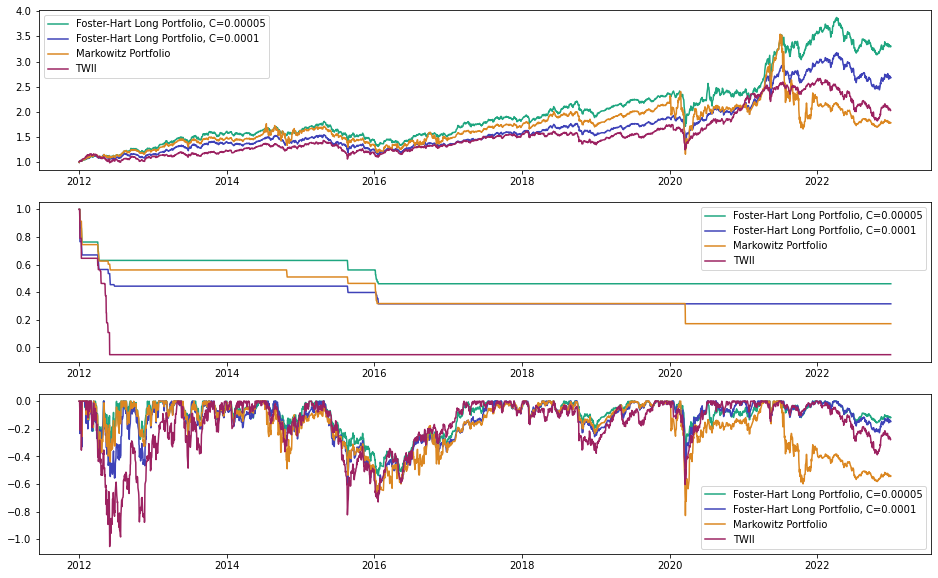

In [28]:
market_index=pd.read_excel('market_index.xlsx')
market_index['年月日']=pd.to_datetime(market_index['年月日'])
market_index.index=market_index['年月日']
market_index=market_index.iloc[..., 2]

market_index = np.log(market_index)
twcumreturn = (market_index.shift(-1)-market_index).cumsum()[:-1]

Buy_data=buy_data.copy().tolist()
Buy_data.append(last_sell_date)

fig, ax = plt.subplots(3, 1, figsize=(16,10))
#ax[0].plot(Price.index, np.exp(np.array(r_2).cumsum()), label='Foster-Hart Long Portfolio, C=0.00001', color='#6088b3')
#ax[0].plot(Price.index, np.exp(np.array(r_5).cumsum()), label='Foster-Hart Long Portfolio, C=0.000025', color='#1c662e')
ax[0].plot(Price.index, np.exp(np.array(r_4).cumsum()), label='Foster-Hart Long Portfolio, C=0.00005', color='#1fa680')
ax[0].plot(Price.index, np.exp(np.array(r_3).cumsum()), label='Foster-Hart Long Portfolio, C=0.0001', color='#3e42b8')
ax[0].plot(Price.index, np.exp(np.array(r_marko).cumsum()), label='Markowitz Portfolio', color='#db8721')
ax[0].plot(np.exp(twcumreturn), label='TWII', color='#9c2261')
#ax[0].plot(np.exp(r_tsmc), label='TSMC', color='#f564df')
ax[0].legend()

mdd_5=pd.DataFrame(np.array(r_5).cumsum())
mdd_5=(mdd_5/mdd_5.cummax()).cummin()
mdd_5.index=Price.index
mdd_4=pd.DataFrame(np.array(r_4).cumsum())
mdd_4=(mdd_4/mdd_4.cummax()).cummin()
mdd_4.index=Price.index
mdd_2=pd.DataFrame(np.array(r_2).cumsum())
mdd_2=(mdd_2/mdd_2.cummax()).cummin()
mdd_2.index=Price.index
mdd_3=pd.DataFrame(np.array(r_3).cumsum())
mdd_3=(mdd_3/mdd_3.cummax()).cummin()
mdd_3.index=Price.index
mdd_marko=pd.DataFrame(np.array(r_marko).cumsum())
mdd_marko=(mdd_marko/mdd_marko.cummax()).cummin()
mdd_marko.index=Price.index
mdd_tw=pd.DataFrame(twcumreturn)
mdd_tw=(mdd_tw/mdd_tw.cummax()).cummin()
#mdd_tsmc=pd.DataFrame(r_tsmc)
#mdd_tsmc=(mdd_tsmc/mdd_tsmc.cummax()).cummin()

#ax[1].plot(mdd_2, label='Foster-Hart Long Portfolio, C=0.00001', color='#6088b3')
#ax[1].plot(mdd_5, label='Foster-Hart Long Portfolio, C=0.000025', color='#1c662e')
ax[1].plot(mdd_4, label='Foster-Hart Long Portfolio, C=0.00005', color='#1fa680')
ax[1].plot(mdd_3, label='Foster-Hart Long Portfolio, C=0.0001', color='#3e42b8')
ax[1].plot(mdd_marko, label='Markowitz Portfolio', color='#db8721')
ax[1].plot(mdd_tw, label='TWII', color='#9c2261')
#ax[1].plot(mdd_tsmc, label='TSMC', color='#f564df')
ax[1].legend()

dd_5=pd.DataFrame(np.array(r_5).cumsum())
dd_5=(dd_5/dd_5.cummax())-1
dd_5.index=Price.index
dd_4=pd.DataFrame(np.array(r_4).cumsum())
dd_4=(dd_4/dd_4.cummax())-1
dd_4.index=Price.index
dd_2=pd.DataFrame(np.array(r_2).cumsum())
dd_2=(dd_2/dd_2.cummax())-1
dd_2.index=Price.index
dd_3=pd.DataFrame(np.array(r_3).cumsum())
dd_3=(dd_3/dd_3.cummax())-1
dd_3.index=Price.index
dd_marko=pd.DataFrame(np.array(r_marko).cumsum())
dd_marko=(dd_marko/dd_marko.cummax())-1
dd_marko.index=Price.index
dd_tw=pd.DataFrame(twcumreturn)
dd_tw=(dd_tw/dd_tw.cummax())-1
#dd_tsmc=pd.DataFrame(r_tsmc)
#dd_tsmc=(dd_tsmc/dd_tsmc.cummax())-1

#ax[2].plot(dd_2, label='Foster-Hart Long Portfolio, C=0.00001', color='#6088b3')
#ax[2].plot(dd_5, label='Foster-Hart Long Portfolio, C=0.000025', color='#1c662e')
ax[2].plot(dd_4, label='Foster-Hart Long Portfolio, C=0.00005', color='#1fa680')
ax[2].plot(dd_3, label='Foster-Hart Long Portfolio, C=0.0001', color='#3e42b8')
ax[2].plot(dd_marko, label='Markowitz Portfolio', color='#db8721')
ax[2].plot(dd_tw, label='TWII', color='#9c2261')
#ax[2].plot(dd_tsmc, label='TSMC', color='#f564df')
ax[2].legend()

"""
plt.figure(figsize=(12, 6))
plt.grid(True)
#plt.plot(Price.index, np.exp(np.array(r).cumsum()), label='Foster-Hart Long Portfolio, C=1')
plt.plot(Price.index, np.exp(np.array(r_2).cumsum()), label='Foster-Hart Long Portfolio, C=0.00001')
plt.plot(Price.index, np.exp(np.array(r_3).cumsum()), label='Foster-Hart Long Portfolio, C=0.0001')
plt.plot(np.exp(twcumreturn), label='TWII')
plt.legend()
"""

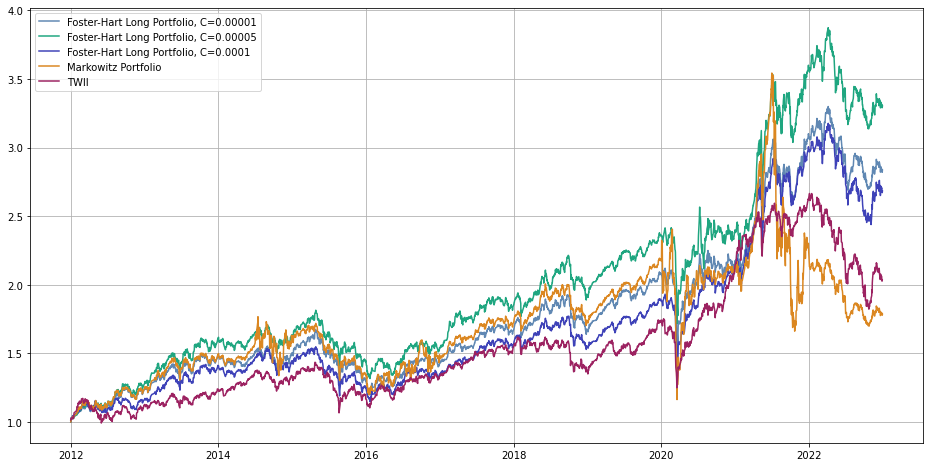

In [29]:
plt.figure(figsize=(16, 8))
plt.grid(True)
plt.plot(Price.index, np.exp(np.array(r_2).cumsum()), label='Foster-Hart Long Portfolio, C=0.00001', color='#6088b3')
#plt.plot(Price.index, np.exp(np.array(r_5).cumsum()), label='Foster-Hart Long Portfolio, C=0.000025', color='#1c662e')
plt.plot(Price.index, np.exp(np.array(r_4).cumsum()), label='Foster-Hart Long Portfolio, C=0.00005', color='#1fa680')
plt.plot(Price.index, np.exp(np.array(r_3).cumsum()), label='Foster-Hart Long Portfolio, C=0.0001', color='#3e42b8')
plt.plot(Price.index, np.exp(np.array(r_marko).cumsum()), label='Markowitz Portfolio', color='#db8721')
plt.plot(np.exp(twcumreturn), label='TWII', color='#9c2261')
plt.legend()

Drawdown 下面積, C=0.00001:  322.96
Drawdown 下面積, C=0.00005:  277.31
Drawdown 下面積, C=0.0001:  361.69
Drawdown 下面積, Markowitz:  534.01
Drawdown 下面積, TWII:  480.35


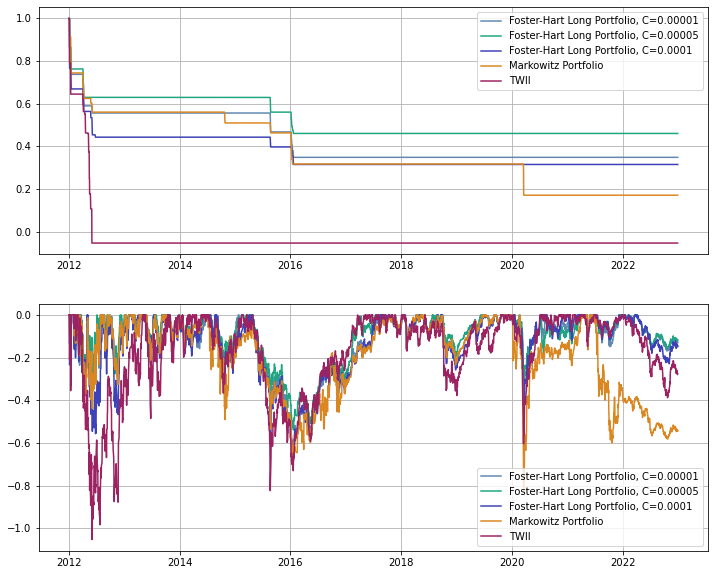

In [30]:
mdd_2=pd.DataFrame(np.array(r_2).cumsum())
mdd_2=(mdd_2/mdd_2.cummax()).cummin()
mdd_2.index=Price.index
mdd_3=pd.DataFrame(np.array(r_3).cumsum())
mdd_3=(mdd_3/mdd_3.cummax()).cummin()
mdd_3.index=Price.index
mdd_4=pd.DataFrame(np.array(r_4).cumsum())
mdd_4=(mdd_4/mdd_4.cummax()).cummin()
mdd_4.index=Price.index
mdd_5=pd.DataFrame(np.array(r_5).cumsum())
mdd_5=(mdd_5/mdd_5.cummax()).cummin()
mdd_5.index=Price.index
mdd_tw=pd.DataFrame(twcumreturn)
mdd_tw=(mdd_tw/mdd_tw.cummax()).cummin()
mdd_marko=pd.DataFrame(np.array(r_marko).cumsum())
mdd_marko=(mdd_marko/mdd_marko.cummax()).cummin()
mdd_marko.index=Price.index

fig, ax = plt.subplots(2, 1, figsize=(12,10))

ax[0].grid(True)
ax[0].plot(mdd_2, label='Foster-Hart Long Portfolio, C=0.00001', color='#6088b3')
#ax[0].plot(mdd_5, label='Foster-Hart Long Portfolio, C=0.000025', color='#1c662e')
ax[0].plot(mdd_4, label='Foster-Hart Long Portfolio, C=0.00005', color='#1fa680')
ax[0].plot(mdd_3, label='Foster-Hart Long Portfolio, C=0.0001', color='#3e42b8')
ax[0].plot(mdd_marko, label='Markowitz Portfolio', color='#db8721')
ax[0].plot(mdd_tw, label='TWII', color='#9c2261')
ax[0].legend()


dd_2=pd.DataFrame(np.array(r_2).cumsum())
dd_2=(dd_2/dd_2.cummax())-1
dd_2.index=Price.index
dd_3=pd.DataFrame(np.array(r_3).cumsum())
dd_3=(dd_3/dd_3.cummax())-1
dd_3.index=Price.index
dd_4=pd.DataFrame(np.array(r_4).cumsum())
dd_4=(dd_4/dd_4.cummax())-1
dd_4.index=Price.index
dd_5=pd.DataFrame(np.array(r_5).cumsum())
dd_5=(dd_5/dd_5.cummax())-1
dd_5.index=Price.index
dd_marko=pd.DataFrame(np.array(r_marko).cumsum())
dd_marko=(dd_marko/dd_marko.cummax())-1
dd_marko.index=Price.index
dd_tw=pd.DataFrame(twcumreturn)
dd_tw=(dd_tw/dd_tw.cummax())-1

ax[1].grid(True)
ax[1].plot(dd_2, label='Foster-Hart Long Portfolio, C=0.00001', color='#6088b3')
#ax[1].plot(dd_5, label='Foster-Hart Long Portfolio, C=0.000025', color='#1c662e')
ax[1].plot(dd_4, label='Foster-Hart Long Portfolio, C=0.00005', color='#1fa680')
ax[1].plot(dd_3, label='Foster-Hart Long Portfolio, C=0.0001', color='#3e42b8')
ax[1].plot(dd_marko, label='Markowitz Portfolio', color='#db8721')
ax[1].plot(dd_tw, label='TWII', color='#9c2261')
ax[1].legend()

print(f"Drawdown 下面積, C=0.00001: {abs(dd_2.sum()[0]): .2f}")
#print(f"Drawdown 下面積, C=0.000025: {abs(dd_5.sum()[0]): .2f}")
print(f"Drawdown 下面積, C=0.00005: {abs(dd_4.sum()[0]): .2f}")
print(f"Drawdown 下面積, C=0.0001: {abs(dd_3.sum()[0]): .2f}")
print(f"Drawdown 下面積, Markowitz: {abs(dd_marko.sum()[0]): .2f}")
print(f"Drawdown 下面積, TWII: {abs(dd_tw.sum()[0]): .2f}")
#print(f"Drawdown 下面積, TSMC: {abs(dd_tsmc.sum()[0]): .2f}")

In [31]:
r_2_sort=r_2.copy()
(r_2_sort).sort()
VaR2=abs(r_2_sort[:int(len(r_2_sort)*0.05)][-1])
Len2=len(r_2_sort)*0.05
ES2=abs(sum(r_2_sort[:int(len(r_2_sort)*0.05)]))/Len2
adjreturn2=np.array(r_2_sort).mean()/np.array(r_2_sort).std()
VaRadjreturn2=np.array(r_2_sort).mean()/VaR2

r_3_sort=r_3.copy()
(r_3_sort).sort()
VaR3=abs(r_3_sort[:int(len(r_3_sort)*0.05)][-1])
Len3=len(r_3_sort)*0.05
ES3=abs(sum(r_3_sort[:int(len(r_3_sort)*0.05)]))/Len3
adjreturn3=np.array(r_3_sort).mean()/np.array(r_3_sort).std()
VaRadjreturn3=np.array(r_3_sort).mean()/VaR3

r_4_sort=r_4.copy()
(r_4_sort).sort()
VaR4=abs(r_4_sort[:int(len(r_4_sort)*0.05)][-1])
Len4=len(r_4_sort)*0.05
ES4=abs(sum(r_4_sort[:int(len(r_4_sort)*0.05)]))/Len4
adjreturn4=np.array(r_4_sort).mean()/np.array(r_4_sort).std()
VaRadjreturn4=np.array(r_4_sort).mean()/VaR4

r_marko_sort=r_marko.copy()
(r_marko_sort).sort()
VaRmarko=abs(r_marko_sort[:int(len(r_marko_sort)*0.05)][-1])
Lenmarko=len(r_marko_sort)*0.05
ESmarko=abs(sum(r_marko_sort[:int(len(r_marko_sort)*0.05)]))/Lenmarko
adjreturnmarko=np.array(r_marko_sort).mean()/np.array(r_marko_sort).std()
VaRadjreturnmarko=np.array(r_marko_sort).mean()/VaRmarko

r_tw_sort=(market_index.shift(-1)-market_index).to_list()
(r_tw_sort).sort()
VaRtw=abs(r_tw_sort[:int(len(r_tw_sort)*0.05)][-1])
Lentw=len(r_tw_sort)*0.05
EStw=abs(sum(r_tw_sort[:int(len(r_tw_sort)*0.05)]))/Lentw
adjreturntw=np.array(r_tw_sort)[:-1].mean()/np.array(r_tw_sort)[:-1].std()
VaRadjreturntw=np.array(r_tw_sort)[:-1].mean()/VaRtw

VaR=pd.DataFrame([VaR3, VaR4, VaRmarko, VaRtw])
VaR.columns=['VaR(0.05)']
VaR['ES(0.05)']=[ES3, ES4, ESmarko, EStw]
VaR['Adjusted Return']=[adjreturn3, adjreturn4, adjreturnmarko, adjreturntw]
VaR['VaR Adjusted Return']=[VaRadjreturn3, VaRadjreturn4, VaRadjreturnmarko, VaRadjreturntw]
VaR.index=['FH, C=0.0001', 'FH C=0.00005', 'Markowitz', 'TWII']
VaR=VaR.T
VaR.to_excel('risk.xlsx')
VaR

,"FH, C=0.0001",FH C=0.00005,Markowitz,TWII
VaR(0.05),0.013709,0.015488,0.021951,0.014956
ES(0.05),0.022336,0.024346,0.045163,0.023281
Adjusted Return,0.039405,0.043852,0.012418,0.027673
VaR Adjusted Return,0.026647,0.028553,0.009764,0.017570


In [56]:
tw = market_index.pct_change()
((tw[1:]>0)*1)*tw[1:]

年月日
2012-01-03    0.001633
2012-01-04    0.000472
2012-01-05    0.000760
2012-01-06   -0.000000
2012-01-09   -0.000000
                ...   
2022-12-26    0.000099
2022-12-27    0.000316
2022-12-28   -0.000000
2022-12-29   -0.000000
2022-12-30    0.000391
Name: Y9999 加權指數, Length: 2701, dtype: float64

In [64]:
data=pd.DataFrame(np.array(r_4[1:])-0.02/365, columns=['FH'])
data['market']=(tw[1:]-0.02/365).to_list()
data['D']=(((tw[1:]>0)*1)*(tw[1:]-0.02/365)).to_list()
data

,FH,market,D
0,0.011211,0.001578,0.001578
1,0.005753,0.000418,0.000418
2,0.008864,0.000705,0.000705
3,-0.003548,-0.000219,-0.000000
4,0.001454,-0.000491,-0.000000
...,...,...,...
2696,0.001657,0.000044,0.000044
2697,0.001921,0.000262,0.000262
2698,-0.004904,-0.001194,-0.000000
2699,-0.002618,-0.000707,-0.000000


In [65]:
results = smf.ols('FH ~ market + D', data=data).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     FH   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     2707.
Date:                Thu, 04 May 2023   Prob (F-statistic):               0.00
Time:                        14:24:50   Log-Likelihood:                 10069.
No. Observations:                2701   AIC:                        -2.013e+04
Df Residuals:                    2698   BIC:                        -2.011e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0009      0.000      5.919      0.0

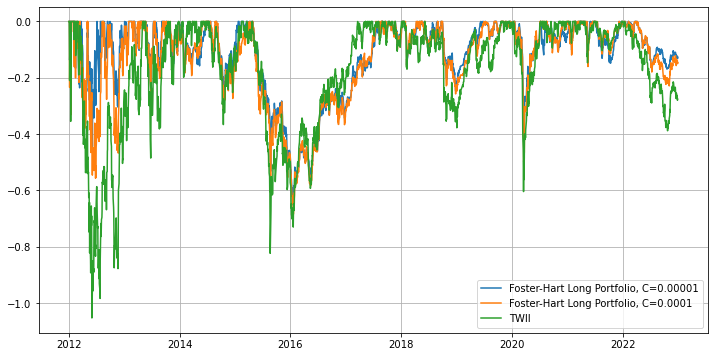

In [309]:
dd_2=pd.DataFrame(np.array(r_2).cumsum())
dd_2=(dd_2/dd_2.cummax())-1
dd_2.index=Price.index
dd_3=pd.DataFrame(np.array(r_3).cumsum())
dd_3=(dd_3/dd_3.cummax())-1
dd_3.index=Price.index
dd_tw=pd.DataFrame(twcumreturn)
dd_tw=(dd_tw/dd_tw.cummax())-1

plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(dd_2, label='Foster-Hart Long Portfolio, C=0.00001')
plt.plot(dd_3, label='Foster-Hart Long Portfolio, C=0.0001')
plt.plot(dd_tw, label='TWII')
plt.legend()

Win rate:  0.52


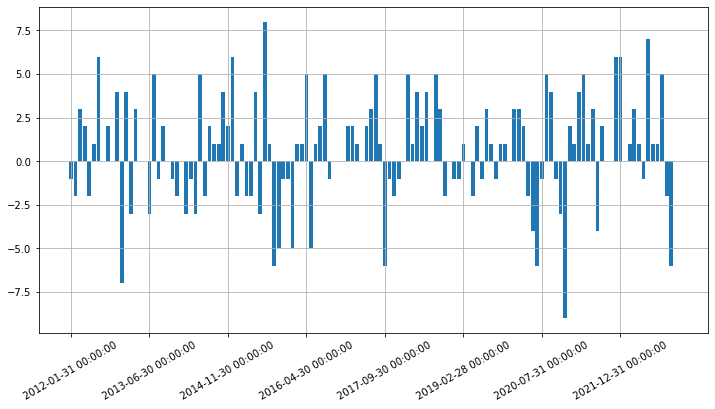

In [139]:
compare=r_2>(market_index.shift(-1)-market_index)
compare.replace({True: 1, False: -1}, inplace=True)
compare=compare.resample('M').sum()


plt.figure(figsize=(12, 6))
plt.grid(True)
x=np.arange(len(compare.index))
plt.bar(x, compare)
plt.xticks(x, compare.index, rotation=30)
plt.locator_params(axis='x', nbins=8)


win=0
for i in compare:
    if(i>0):
        win+=1
print(f"Win rate: {win/len(compare): .2f}")

Foster-Hart Long Portfolio, C=0.00001 的賺賠比:  1.08
TWII 的賺賠比:  0.88


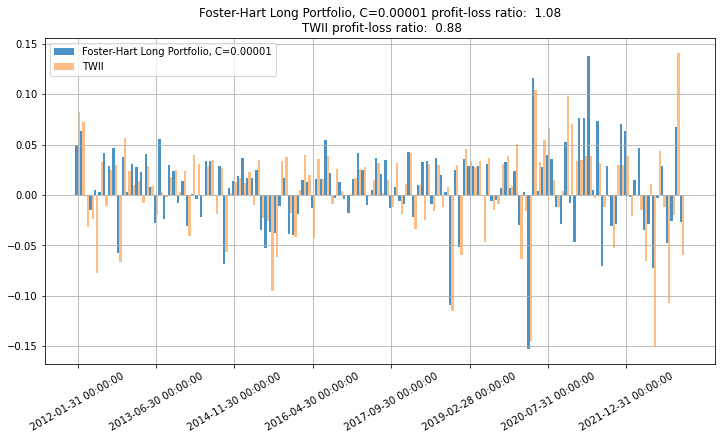

In [435]:
R_2=pd.DataFrame(r_2)
R_2.index=Price.index
R_2=R_2.resample('M').sum()

tw_return=(market_index.shift(-1)-market_index)
tw_return=tw_return.resample('M').sum()

plt.figure(figsize=(12, 6))
plt.grid(True)
x=np.arange(len(R_2.index))
plt.bar(x-0.25, R_2.iloc[..., 0], alpha=0.8, width=0.5 ,label='Foster-Hart Long Portfolio, C=0.00001')
plt.bar(x+0.25, tw_return, alpha=0.5, width=0.5, label='TWII')
plt.xticks(x, compare.index, rotation=30)
plt.locator_params(axis='x', nbins=8)
plt.title(f"Foster-Hart Long Portfolio, C=0.00001 profit-loss ratio: {abs(R_2[R_2.iloc[..., 0]>0].mean()/R_2[R_2.iloc[..., 0]<0].mean())[0]: .2f}\n TWII profit-loss ratio: {abs(tw_return[tw_return>0].mean()/tw_return[tw_return<0].mean()): .2f}")
plt.legend()


print(f"Foster-Hart Long Portfolio, C=0.00001 的賺賠比: {abs(R_2[R_2.iloc[..., 0]>0].mean()/R_2[R_2.iloc[..., 0]<0].mean())[0]: .2f}")
print(f"TWII 的賺賠比: {abs(tw_return[tw_return>0].mean()/tw_return[tw_return<0].mean()): .2f}")

Win rate (compare with TWII):  0.53


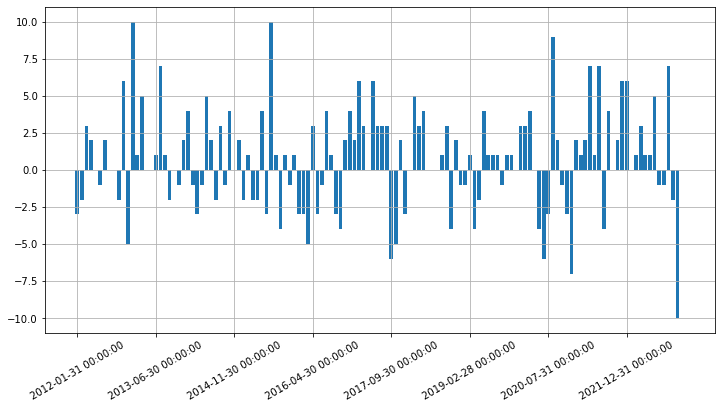

In [410]:
compare=r_4>(market_index.shift(-1)-market_index)
compare.replace({True: 1, False: -1}, inplace=True)
compare=compare.resample('M').sum()


plt.figure(figsize=(12, 6))
plt.grid(True)
x=np.arange(len(compare.index))
plt.bar(x, compare)
plt.xticks(x, compare.index, rotation=30)
plt.locator_params(axis='x', nbins=8)


win=0
for i in compare:
    if(i>0):
        win+=1
print(f"Win rate (compare with TWII): {win/len(compare): .2f}")

Win rate:  0.63


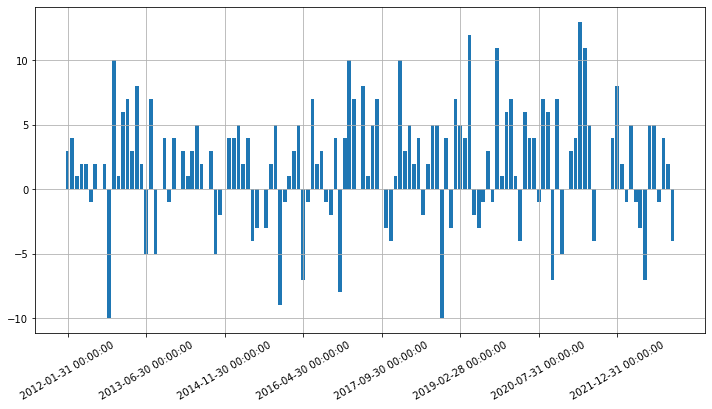

In [423]:
compare=(pd.DataFrame(r_4)>0).iloc[:, 0]
compare.index=market_index.index
compare.replace({True: 1, False: -1}, inplace=True)
compare=compare.resample('M').sum()


plt.figure(figsize=(12, 6))
plt.grid(True)
x=np.arange(len(compare.index))
plt.bar(x, compare)
plt.xticks(x, compare.index, rotation=30)
plt.locator_params(axis='x', nbins=8)


win=0
for i in compare:
    if(i>0):
        win+=1
print(f"Win rate: {win/len(compare): .2f}")

Foster-Hart Long Portfolio, C=0.00005 的賺賠比:  1.20
TWII 的賺賠比:  0.88


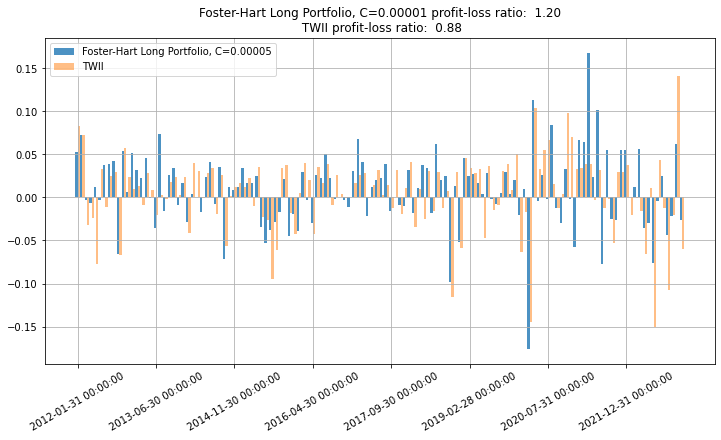

In [434]:
R_4=pd.DataFrame(r_4)
R_4.index=Price.index
R_4=R_4.resample('M').sum()

tw_return=(market_index.shift(-1)-market_index)
tw_return=tw_return.resample('M').sum()

plt.figure(figsize=(12, 6))
plt.grid(True)
x=np.arange(len(R_4.index))
plt.bar(x-0.25, R_4.iloc[..., 0], alpha=0.8, width=0.5 ,label='Foster-Hart Long Portfolio, C=0.00005')
plt.bar(x+0.25, tw_return, alpha=0.5, width=0.5, label='TWII')
plt.xticks(x, compare.index, rotation=30)
plt.locator_params(axis='x', nbins=8)
plt.title(f"Foster-Hart Long Portfolio, C=0.00001 profit-loss ratio: {abs(R_4[R_4.iloc[..., 0]>0].mean()/R_4[R_4.iloc[..., 0]<0].mean())[0]: .2f}\n TWII profit-loss ratio: {abs(tw_return[tw_return>0].mean()/tw_return[tw_return<0].mean()): .2f}")
plt.legend()


print(f"Foster-Hart Long Portfolio, C=0.00005 的賺賠比: {abs(R_4[R_4.iloc[..., 0]>0].mean()/R_4[R_4.iloc[..., 0]<0].mean())[0]: .2f}")
print(f"TWII 的賺賠比: {abs(tw_return[tw_return>0].mean()/tw_return[tw_return<0].mean()): .2f}")

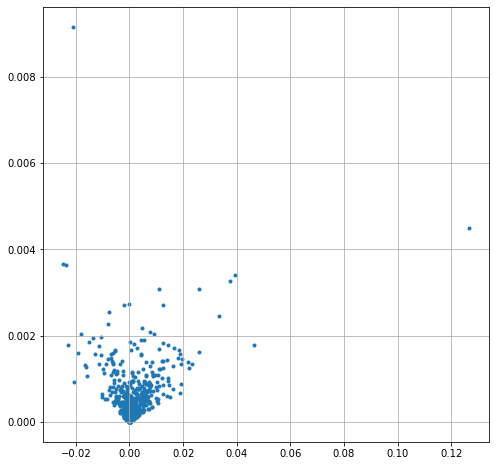

In [526]:
mean_variance_4_pd=pd.DataFrame(mean_variance_4)
mean_variance_4_pd.columns=['mean', 'std']
plt.figure(figsize=(8, 8))
plt.grid(True)
plt.scatter(mean_variance_4_pd['mean']*100, mean_variance_4_pd['std'], marker='.')


In [363]:
M=[]

for i in range(len(Buy_data)-1):
    weight=Weight_4[i]
    test=price.iloc[price.index<Buy_data[i+1]]
    test=test.iloc[test.index>Buy_data[i]]
    test=np.log(test.shift(-1)/test).resample("M").sum()
    test=test[buy[i]]
    monthly_return=np.dot(test, weight)
    m=[]
    for j in monthly_return:
        m.append(j)
    M.append(m)
print(np.array(M).mean(axis=0)*100)
    

[ 0.83861124  2.38192834 -0.08689324  0.86409037  1.04995179  0.20671369]


In [455]:
BUY=pd.DataFrame(buy)
#BUY.index=price.iloc[buy_date_index].index
BUY

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,9933 中鼎,2330 台積電,1216 統一,9921 巨大,3045 台灣大,2412 中華電,4904 遠傳,2347 聯強,8299 群聯,2103 台橡,...,2227 裕日車,2395 研華,2385 群光,2324 仁寶,3034 聯詠,4938 和碩,2357 華碩,1504 東元,1227 佳格,1102 亞泥
1,3045 台灣大,2227 裕日車,1216 統一,2105 正新,9945 潤泰新,3034 聯詠,2385 群光,6176 瑞儀,9904 寶成,2395 研華,...,2412 中華電,8299 群聯,2002 中鋼,1504 東元,1102 亞泥,2308 台達電,5903 全家,2357 華碩,4938 和碩,2912 統一超
2,2881 富邦金,2395 研華,1504 東元,2880 華南金,2887 台新金,2412 中華電,5347 世界,9945 潤泰新,1102 亞泥,1101 台泥,...,1216 統一,2451 創見,2385 群光,2915 潤泰全,2207 和泰車,2892 第一金,2301 光寶科,2105 正新,6147 頎邦,9904 寶成
3,2303 聯電,2412 中華電,3045 台灣大,1565 精華,2912 統一超,4904 遠傳,2884 玉山金,9921 巨大,3189 景碩,2882 國泰金,...,1216 統一,9907 統一實,2880 華南金,5880 合庫金,2606 裕民,2106 建大,2385 群光,2105 正新,2890 永豐金,2885 元大金
4,1227 佳格,2890 永豐金,2883 開發金,2801 彰銀,1301 台塑,2892 第一金,2308 台達電,2727 王品,2891 中信金,2362 藍天,...,1402 遠東新,2885 元大金,2886 兆豐金,3008 大立光,1101 台泥,2606 裕民,1504 東元,2887 台新金,2474 可成,5880 合庫金
5,2330 台積電,2344 華邦電,2049 上銀,2317 鴻海,6121 新普,2834 臺企銀,2409 友達,1102 亞泥,2395 研華,5880 合庫金,...,2385 群光,2801 彰銀,2382 廣達,2412 中華電,1301 台塑,2303 聯電,2887 台新金,1723 中碳,3037 欣興,2882 國泰金
6,2603 長榮,3045 台灣大,2412 中華電,9910 豐泰,2609 陽明,4904 遠傳,2330 台積電,3034 聯詠,2884 玉山金,2002 中鋼,...,2883 開發金,2610 華航,2409 友達,2615 萬海,2834 臺企銀,5871 中租-KY,2892 第一金,5880 合庫金,2606 裕民,2809 京城銀
7,2474 可成,1476 儒鴻,1227 佳格,2451 創見,1216 統一,2354 鴻準,2412 中華電,2891 中信金,2886 兆豐金,6239 力成,...,1477 聚陽,2317 鴻海,1402 遠東新,2881 富邦金,2884 玉山金,3702 大聯大,2347 聯強,4958 臻鼎-KY,2330 台積電,4904 遠傳
8,2412 中華電,2377 微星,1301 台塑,9917 中保科,1227 佳格,3691 碩禾,2356 英業達,6409 旭隼,2330 台積電,3045 台灣大,...,6239 力成,2915 潤泰全,1789 神隆,2892 第一金,2880 華南金,2327 國巨,2882 國泰金,9945 潤泰新,2834 臺企銀,1504 東元
9,2330 台積電,3045 台灣大,6239 力成,4904 遠傳,5347 世界,2412 中華電,2892 第一金,2912 統一超,2542 興富發,2379 瑞昱,...,2801 彰銀,2353 宏碁,9933 中鼎,3105 穩懋,2301 光寶科,5880 合庫金,2634 漢翔,2887 台新金,1301 台塑,2723 美食-KY


In [505]:
pd.DataFrame(buy[1]).to_excel("2012-07-02 target.xlsx")

In [190]:
Weight_pd=[]
Weight_2_pd=[]
for i in range(len(Weight)):
    #Weight_pd.append(pd.DataFrame([buy[i], Weight[i]]))
    #Weight_2_pd.append(pd.DataFrame([buy[i], Weight_2[i]]))
    w_1=pd.DataFrame([buy[i], Weight[i]]).T
    w_2=pd.DataFrame([buy[i], Weight_2[i]]).T
    w_1.columns=['tickers', 'weight']
    w_2.columns=['tickers', 'weight']
    w_1.sort_values(by=['weight'], ascending=False, inplace=True)
    w_1.index=range(30)
    w_2.sort_values(by=['weight'], ascending=False, inplace=True)
    w_2.index=range(30)
    Weight_pd.append(w_1)
    Weight_2_pd.append(w_2)


In [191]:
display(pd.concat([Weight_pd[0], Weight_2_pd[0]], axis=1))

,tickers,weight,tickers,weight
0,1102 亞泥,0.163626,3045 台灣大,0.074445
1,1504 東元,0.143981,4904 遠傳,0.069954
2,2324 仁寶,0.100345,2385 群光,0.063786
3,3034 聯詠,0.087717,1216 統一,0.062199
4,2103 台橡,0.078647,4938 和碩,0.055938
5,9933 中鼎,0.063158,1102 亞泥,0.051071
6,2412 中華電,0.046256,2105 正新,0.050621
7,8299 群聯,0.042135,1434 福懋,0.048637
8,2301 光寶科,0.039952,2395 研華,0.043981
9,9904 寶成,0.037548,2347 聯強,0.043501


In [444]:
r[buy[0]].loc[:data.columns[0]].iloc[-252:].cov()

,9933 中鼎,2330 台積電,1216 統一,9921 巨大,3045 台灣大,2412 中華電,4904 遠傳,2347 聯強,8299 群聯,2103 台橡,...,2227 裕日車,2395 研華,2385 群光,2324 仁寶,3034 聯詠,4938 和碩,2357 華碩,1504 東元,1227 佳格,1102 亞泥
9933 中鼎,0.000193,0.000071,0.000087,0.000038,0.000035,0.000037,0.000059,0.000058,0.000112,0.000112,...,0.000075,0.000080,0.000107,0.000082,0.000107,0.000080,0.000097,0.000082,0.000073,0.000120
2330 台積電,0.000071,0.000219,0.000132,0.000139,0.000056,0.000049,0.000071,0.000116,0.000190,0.000151,...,0.000122,0.000134,0.000169,0.000181,0.000199,0.000181,0.000161,0.000128,0.000153,0.000159
1216 統一,0.000087,0.000132,0.000345,0.000149,0.000054,0.000048,0.000030,0.000168,0.000139,0.000165,...,0.000162,0.000159,0.000162,0.000173,0.000192,0.000246,0.000173,0.000174,0.000179,0.000251
9921 巨大,0.000038,0.000139,0.000149,0.000433,0.000053,0.000049,0.000046,0.000147,0.000174,0.000138,...,0.000093,0.000186,0.000180,0.000176,0.000165,0.000225,0.000123,0.000168,0.000142,0.000190
3045 台灣大,0.000035,0.000056,0.000054,0.000053,0.000144,0.000037,0.000040,0.000037,0.000079,0.000074,...,0.000057,0.000068,0.000068,0.000065,0.000082,0.000098,0.000043,0.000067,0.000066,0.000064
2412 中華電,0.000037,0.000049,0.000048,0.000049,0.000037,0.000069,0.000052,0.000033,0.000063,0.000061,...,0.000039,0.000051,0.000058,0.000047,0.000053,0.000077,0.000041,0.000045,0.000054,0.000046
4904 遠傳,0.000059,0.000071,0.000030,0.000046,0.000040,0.000052,0.000210,0.000047,0.000114,0.000082,...,0.000062,0.000072,0.000096,0.000078,0.000097,0.000096,0.000062,0.000068,0.000076,0.000072
2347 聯強,0.000058,0.000116,0.000168,0.000147,0.000037,0.000033,0.000047,0.000368,0.000182,0.000172,...,0.000183,0.000144,0.000176,0.000169,0.000208,0.000194,0.000205,0.000190,0.000209,0.000222
8299 群聯,0.000112,0.000190,0.000139,0.000174,0.000079,0.000063,0.000114,0.000182,0.000699,0.000210,...,0.000209,0.000145,0.000252,0.000238,0.000296,0.000245,0.000245,0.000176,0.000196,0.000217
2103 台橡,0.000112,0.000151,0.000165,0.000138,0.000074,0.000061,0.000082,0.000172,0.000210,0.000563,...,0.000150,0.000168,0.000227,0.000170,0.000258,0.000192,0.000135,0.000190,0.000197,0.000233


In [445]:
Ratio=data[data.columns[0]].loc[buy[0]]/data[data.columns[0]].loc[buy[0]].sum()

In [446]:
Mean=(r[buy[0]].loc[:data.columns[0]].iloc[-252:]*Ratio).mean().sum()
Variance=0
Covariance=(r[buy[0]].loc[:data.columns[0]].iloc[-252:]*Ratio).cov()
for i in range(Covariance.shape[0]):
    Variance+=Covariance.iloc[i][i:].sum()
print(Mean, Variance)

0.0005465203771670047 7.709026811614838e-05


In [447]:
(r[buy[0]].loc[:data.columns[0]].iloc[-252:]*Ratio).cov()

,9933 中鼎,2330 台積電,1216 統一,9921 巨大,3045 台灣大,2412 中華電,4904 遠傳,2347 聯強,8299 群聯,2103 台橡,...,2227 裕日車,2395 研華,2385 群光,2324 仁寶,3034 聯詠,4938 和碩,2357 華碩,1504 東元,1227 佳格,1102 亞泥
9933 中鼎,3.774164e-09,9.220787e-08,1.155833e-08,1.099571e-09,7.537205e-09,1.886472e-08,7.314544e-09,4.395505e-09,2.435717e-09,3.945649e-09,...,1.941275e-09,2.476399e-09,2.264322e-09,7.230721e-09,3.243865e-09,3.962783e-09,1.047688e-08,1.783682e-09,2.061502e-09,8.500540e-09
2330 台積電,9.220787e-08,1.907377e-05,1.174484e-06,2.699099e-07,7.960479e-07,1.675681e-06,5.811327e-07,5.893883e-07,2.745485e-07,3.550062e-07,...,2.109653e-07,2.763175e-07,2.401768e-07,1.069658e-06,4.027737e-07,5.967697e-07,1.156534e-06,1.856449e-07,2.897295e-07,7.540881e-07
1216 統一,1.155833e-08,1.174484e-06,3.148317e-07,2.976586e-08,7.952979e-08,1.701099e-07,2.542780e-08,8.768273e-08,2.056853e-08,3.988663e-08,...,2.854964e-08,3.343749e-08,2.357112e-08,1.042430e-07,3.978649e-08,8.307499e-08,1.274639e-07,2.590485e-08,3.463653e-08,1.213688e-07
9921 巨大,1.099571e-09,2.699099e-07,2.976586e-08,1.883064e-08,1.710124e-08,3.766127e-08,8.385663e-09,1.675388e-08,5.625296e-09,7.239161e-09,...,3.592930e-09,8.518521e-09,5.720996e-09,2.315335e-08,7.482688e-09,1.657181e-08,1.974619e-08,5.459105e-09,5.990844e-09,2.007895e-08
3045 台灣大,7.537205e-09,7.960479e-07,7.952979e-08,1.710124e-08,3.379691e-07,2.078151e-07,5.463716e-08,3.056276e-08,1.872063e-08,2.852303e-08,...,1.611266e-08,2.284897e-08,1.589354e-08,6.276458e-08,2.726773e-08,5.294174e-08,5.055752e-08,1.592374e-08,2.056827e-08,4.998287e-08
2412 中華電,1.886472e-08,1.675681e-06,1.701099e-07,3.766127e-08,2.078151e-07,9.386621e-07,1.685230e-07,6.731840e-08,3.625678e-08,5.678551e-08,...,2.664705e-08,4.140515e-08,3.266814e-08,1.094993e-07,4.244806e-08,1.001981e-07,1.163318e-07,2.570778e-08,4.052719e-08,8.622302e-08
4904 遠傳,7.314544e-09,5.811327e-07,2.542780e-08,8.385663e-09,5.463716e-08,1.685230e-07,1.633388e-07,2.271534e-08,1.560595e-08,1.833967e-08,...,1.002345e-08,1.391721e-08,1.289859e-08,4.366477e-08,1.846971e-08,2.991111e-08,4.235421e-08,9.362566e-09,1.354495e-08,3.211514e-08
2347 聯強,4.395505e-09,5.893883e-07,8.768273e-08,1.675388e-08,3.056276e-08,6.731840e-08,2.271534e-08,1.096378e-07,1.540535e-08,2.363641e-08,...,1.844579e-08,1.724208e-08,1.458423e-08,5.830845e-08,2.465165e-08,3.737995e-08,8.632353e-08,1.615576e-08,2.306889e-08,6.149037e-08
8299 群聯,2.435717e-09,2.745485e-07,2.056853e-08,5.625296e-09,1.872063e-08,3.625678e-08,1.560595e-08,1.540535e-08,1.681403e-08,8.234648e-09,...,5.988517e-09,4.938767e-09,5.951863e-09,2.325715e-08,9.974269e-09,1.344488e-08,2.932559e-08,4.245846e-09,6.153534e-09,1.703256e-08
2103 台橡,3.945649e-09,3.550062e-07,3.988663e-08,7.239161e-09,2.852303e-08,5.678551e-08,1.833967e-08,2.363641e-08,8.234648e-09,3.584357e-08,...,6.989181e-09,9.315130e-09,8.715892e-09,2.712656e-08,1.415918e-08,1.714067e-08,2.623347e-08,7.468872e-09,1.006610e-08,2.980459e-08
